In [79]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from rfest import splineLNP, splineLNLN, GLM, LNP
from rfest.utils import split_data

In [2]:
def norm(x):
    return x / np.linalg.norm(x)

In [3]:
data = scipy.io.loadmat('./data/hafting_et_al/Hafting_Fig2d_Trial1.mat')

In [4]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'pos_x', 'pos_y', 'pos_timeStamps', 'rat11015_t1c1', 'rat11015_t2c1', 'rat11015_t2c2'])

In [5]:
pos = np.hstack([data['pos_x'], data['pos_y']])
postime = data['pos_timeStamps'].flatten()
spiketime = data['rat11015_t1c1'].flatten()

y = np.zeros(pos.shape[0])
pos_spike = [np.where(spiketime[i] <= postime)[0][0] for i in range(len(spiketime))]
y[pos_spike] = 1

y = y[~np.isnan(pos).all(1)]
pos = pos[~np.isnan(pos).all(1)]

In [116]:
dims

(24, 24)

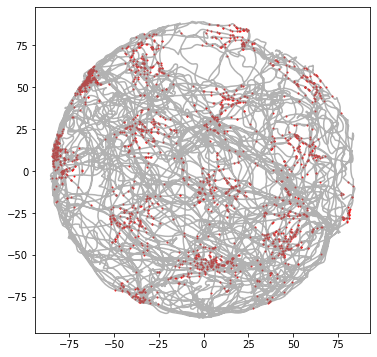

In [7]:
plt.figure(figsize=(6,6))
plt.plot(pos[:, 0], pos[:, 1], color='gray', alpha=0.6)
plt.scatter(pos[pos_spike][:, 0], pos[pos_spike][:, 1], color='red', s=1)

In [8]:
plt.figure(figsize=(6,6))
counts, xbins, ybins, _ = plt.hist2d(pos[pos_spike][:, 0], pos[pos_spike][:, 1], bins=29, 
               cmap='Reds')
plt.close()
X = np.zeros([pos.shape[0], len(xbins), len(ybins)])
for i in range(pos.shape[0]):
    condx = np.where(pos[i][0] < xbins)[0]
    if len(condx) > 0:
        condx = condx[0]
    else:
        condx = len(xbins)-1
        
    condy = np.where(pos[i][1] < ybins)[0]
    if len(condy) > 0:
        condy = condy[0]
    else:
        condy = len(ybins)-1    

#     cond = np.array([condx, condy])
    X[i][condx, condy] = 1

cut = 3
Xdsgn = X[:, cut:-cut, cut:-cut]
# Xdsgn = X
# plt.figure(figsize=(6,6))
# plt.imshow(Xdsgn[pos_spike].mean(0).T, cmap='Reds', origin='lower')

dims = Xdsgn.shape[1:]
Xdsgn = Xdsgn.reshape(Xdsgn.shape[0], np.prod(Xdsgn.shape[1:]))



In [26]:
(X_train, y_train), (X_dev, y_dev), (X_test, y_test) = split_data(Xdsgn, y, dt=0.02, frac_train=0.5, frac_dev=0.1)

SUMMARY
               N    Minutes   Fraction
Total      59587      19.86        1.0
Train      29790       9.93        0.5
Dev         5970       1.99        0.1
Test       23827       7.94        0.4


In [98]:
lnpnospl = LNP(X_train, y_train, dims=dims, dt=0.02, nonlinearity='exponential')
lnpnospl.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', num_iters=1000, alpha=1, beta=.5, step_size=0.1, verbose=100)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     1.435	   551.913	   102.801	     0.173	     0.096
  100	     6.740	   159.979	   123.090	     0.268	     0.080
  200	    12.002	   159.744	   123.290	     0.268	     0.080
  300	    17.037	   159.671	   123.334	     0.268	     0.080
  400	    24.916	   159.965	   123.101	     0.268	     0.080
  500	    33.108	   160.031	   123.383	     0.268	     0.080
  600	    41.135	   159.760	   123.022	     0.268	     0.080
  700	    49.382	   159.818	   122.559	     0.268	     0.080
  800	    57.109	   159.812	   123.196	     0.268	     0.080
  900	    63.878	   159.701	   123.236	     0.268	     0.080
Stop: reached 1000 steps.

Total time elapsed: 70.189 s.


In [75]:
lnp = splineLNP(X_train, y_train, df=[11, 11], dims=dims, dt=0.02, nonlinearity='exponential')
lnp.fit(extra={'X': X_dev, 'y': y_dev}, metric='corrcoef', num_iters=1000, alpha=1, beta=.1, step_size=0.1, verbose=100)

Iters	  Time (s)	Cost (train)	Cost (dev)	Metric (train)	Metric (dev)
    0	     0.629	   585.790	   109.796	     0.146	     0.117
  100	     2.998	   454.427	    81.311	     0.188	     0.148
  200	     5.474	   385.498	    67.406	     0.202	     0.155
  300	     7.975	   346.637	    61.898	     0.210	     0.156
  400	    11.527	   322.360	    60.436	     0.215	     0.155
  500	    15.182	   306.651	    60.071	     0.218	     0.154
  600	    20.298	   296.486	    59.965	     0.219	     0.153
Stop at 682 steps: cost (dev) has been monotonically increasing for 10 steps.

Total time elapsed: 24.282 s.


In [76]:
pos_spike_sub = [spike for spike in pos_spike if spike < 29790]

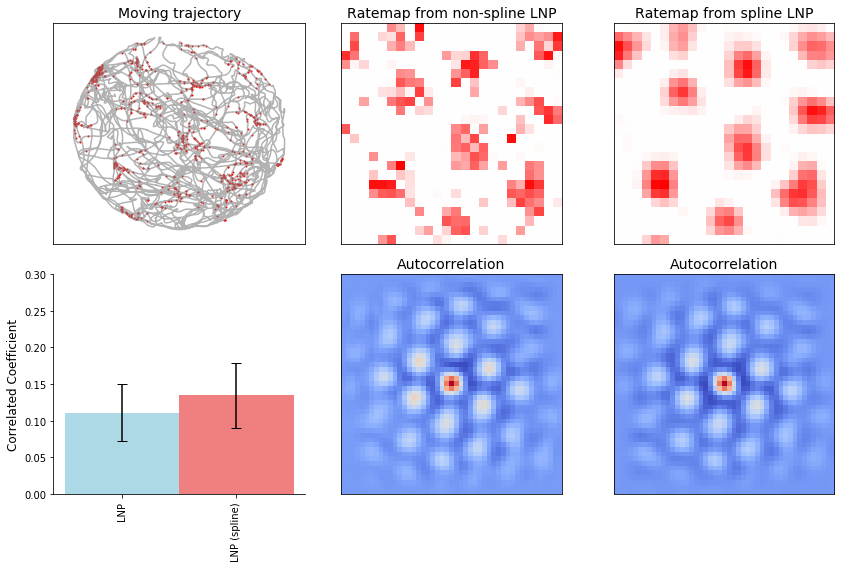

In [115]:
from scipy.signal import correlate2d


fig, ax = plt.subplots(2,3, figsize=(12,8))
ax = ax.flatten()
ax[0].plot(pos[:, 0][:29790], pos[:, 1][:29790], color='gray', alpha=0.6)
ax[0].scatter(pos[pos_spike_sub][:, 0], pos[pos_spike_sub][:, 1], color='red', s=1)
ax[0].set_xlim(-100, 100)
ax[0].set_ylim(-100, 100)
ax[0].set_title('Moving trajectory', fontsize=14)

ratemap = lnpnospl.w_opt.reshape(dims).T
# ratemap = Xdsgn.sum(0).reshape(dims).T
vmax = np.max([np.abs(ratemap.min()), np.abs(ratemap.max())])
ax[1].imshow(np.maximum(0, ratemap), 
           cmap=plt.cm.bwr, origin='lower', vmin=-vmax, vmax=vmax)
ax[1].set_title('Ratemap from non-spline LNP', fontsize=14)
vmax = np.max([np.abs(ratemap.min()), np.abs(ratemap.max())])

spline_ratemap = lnp.w_opt.reshape(dims).T
vmax = np.max([np.abs(spline_ratemap.min()), np.abs(spline_ratemap.max())])

ax[2].imshow(np.maximum(0, spline_ratemap), 
           cmap=plt.cm.bwr, origin='lower', vmin=-vmax, vmax=vmax)
ax[2].set_title('Ratemap from spline LNP', fontsize=14)

ac = correlate2d(ratemap.T, lnp.w_opt.reshape(dims))
ax[4].imshow(ac.T, cmap=plt.cm.coolwarm, origin='lower')
ax[4].set_title('Autocorrelation', fontsize=14)

ac = correlate2d(spline_ratemap.T, lnp.w_opt.reshape(dims))
ax[5].imshow(ac.T, cmap=plt.cm.coolwarm, origin='lower')
ax[5].set_title('Autocorrelation', fontsize=14)

for i in [0, 1, 2, 4, 5]:
    ax[i].set_xticks([])
    ax[i].set_yticks([])
# ax[3].axis('off')

div = int(X_test.shape[0]/4)
cc_test = np.array([[m.score(X_test[i*div:(i+1)*div], y_test[i*div:(i+1)*div]) for m 
                     in [lnpnospl, lnp]] for i
                     in range(4)])
cc_test_mean = cc_test.mean(0)
cc_test_std = cc_test.std(0)
x = [0, 1]
ax[3].bar(x, cc_test_mean, yerr=cc_test_std, 
              width=1, 
              color=['lightblue', 'lightcoral'], 
              capsize=5)

labels = ['LNP', 'LNP (spline)']
ax[3].spines['top'].set_visible(False)
ax[3].spines['right'].set_visible(False)
ax[3].set_xticks(x)
ax[3].set_xticklabels(labels, rotation=90)
ax[3].set_ylim(0, 0.3)
ax[3].set_ylabel('Correlated Coefficient', fontsize=12)

fig.tight_layout()
fig.savefig('./figures/SupFigure_Gridcell.pdf')